# Laplacian Spectral Bounds Investigation

This notebook investigates the results from the Laplacian spectral bounds experiment,
focusing on graphs that violate the bound (i.e., where max_eigval > bound).


In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch

# Add project root directory to path to import experiment code
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from experiments.laplacian_spectral_bounds import (
    LaplacianSpectralBound,
    bound31,
    bound1,
    bound4,
    bound5,
)
from combo_dl.graph_utils import edge_vec_to_adj, adj_to_edge_vec

device = torch.device("cpu")
torch.set_default_dtype(torch.float32)


/sciclone/home/jnelmore/thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Find the most recent laplacian spectral bounds run
runs_dir = Path("../runs")
laplacian_runs = [
    d for d in runs_dir.iterdir()
    if d.is_dir() and "laplacian" in d.name
]
laplacian_runs.sort(key=lambda x: x.name, reverse=True)

print("Available Laplacian Spectral Bounds runs:")
for i, run_dir in enumerate(laplacian_runs[:10]):  # Show last 10
    print(f"{i}: {run_dir.name}")

# Select the most recent run
selected_run = laplacian_runs[0] if laplacian_runs else None
print(f"\nSelected run: {selected_run.name if selected_run else 'None'}")


Available Laplacian Spectral Bounds runs:
0: 20251111_130506_laplacian_bound3_hpc

Selected run: 20251111_130506_laplacian_bound3_hpc


In [3]:
# Load best constructions
if selected_run is None:
    raise ValueError("No laplacian spectral bounds runs found!")

best_constructions_dir = selected_run / "best_constructions"
construction_files = sorted(best_constructions_dir.glob("best_iter_*_score_*.pt"))

constructions_data = []
for file in construction_files:
    # Load the construction file (it's a dictionary)
    loaded_data = torch.load(file, map_location=device)
    
    # Extract data from the dictionary
    if isinstance(loaded_data, dict):
        edge_vec = loaded_data["construction"]
        # Use score from file if available, otherwise parse from filename
        score = loaded_data.get("score", float("nan"))
        iteration = loaded_data.get("iteration", -1)
    else:
        # Fallback: if it's just a tensor, parse from filename
        edge_vec = loaded_data
        parts = file.stem.split("_")
        iteration = int(parts[2])
        score = float(parts[4])
    
    constructions_data.append({
        "iteration": iteration,
        "score": score,
        "edge_vec": edge_vec,
        "file": file,
    })

# Sort by iteration
constructions_data.sort(key=lambda x: x["iteration"])

print(f"Loaded {len(constructions_data)} best constructions")
print(f"\nScore progression:")
for data in constructions_data[-10:]:  # Show last 10
    print(f"  Iter {data['iteration']:3d}: score = {data['score']:8.4f}")


Loaded 19 best constructions

Score progression:
  Iter 177: score =  -1.6342
  Iter 216: score =  -1.5188
  Iter 217: score =  -1.4416
  Iter 219: score =  -1.2680
  Iter 222: score =  -1.0197
  Iter 233: score =  -0.6250
  Iter 237: score =   0.0000
  Iter 241: score =   0.0000
  Iter 244: score =   0.0000
  Iter 266: score =   0.0459


In [5]:
# Extract graph properties for each construction
n = 21  # From the experiment
problem = LaplacianSpectralBound(bound31, n)

def analyze_graph(edge_vec: torch.Tensor, problem: LaplacianSpectralBound) -> dict:
    """Analyze a graph and compute its properties."""
    # Ensure edge_vec is a tensor and has the right shape
    if not isinstance(edge_vec, torch.Tensor):
        edge_vec = torch.tensor(edge_vec)
    
    # Add batch dimension if needed
    if edge_vec.dim() == 1:
        edge_vec = edge_vec.unsqueeze(0)
    
    adj = edge_vec_to_adj(edge_vec, problem.n)
    adj_np = adj[0].numpy().astype(int)
    
    # Compute Laplacian
    degrees = adj.sum(dim=1)[0]  # (n,)
    degree_mat = torch.diag_embed(degrees.unsqueeze(0), dim1=-2, dim2=-1)
    laplacian = (degree_mat - adj)[0].numpy()
    
    # Eigenvalues
    eigvals = np.linalg.eigvals(laplacian).real
    max_eigval = np.max(eigvals)
    
    # Compute bound
    degrees_expanded = degrees.unsqueeze(-1)
    neighbor_degree_sums = (adj @ degrees_expanded.unsqueeze(0)).squeeze(-1)[0]
    avg_neighbor_degrees = neighbor_degree_sums / (degrees + 1e-8)
    
    vertex_scores = problem.bound(degrees.unsqueeze(0), avg_neighbor_degrees.unsqueeze(0))
    bound = torch.max(vertex_scores).item()
    
    # Graph properties
    G = nx.from_numpy_array(adj_np)
    
    return {
        "adj": adj_np,
        "degrees": degrees.numpy(),
        "avg_neighbor_degrees": avg_neighbor_degrees.numpy(),
        "max_eigval": max_eigval,
        "bound": bound,
        "reward": max_eigval - bound,
        "violates_bound": max_eigval > bound,
        "graph": G,
        "num_edges": G.number_of_edges(),
        "is_connected": nx.is_connected(G),
        "num_components": nx.number_connected_components(G),
        "density": nx.density(G),
        "avg_degree": np.mean(degrees.numpy()),
        "max_degree": int(degrees.max().item()),
        "min_degree": int(degrees.min().item()),
    }

# Analyze all constructions
for data in constructions_data:
    analysis = analyze_graph(data["edge_vec"], problem)
    data.update(analysis)

print("Analysis complete!")
print(f"\nGraphs that violate the bound:")
violating = [d for d in constructions_data if d["violates_bound"]]
print(f"  Count: {len(violating)}")
for v in violating:
    print(f"  Iter {v['iteration']:3d}: max_eigval={v['max_eigval']:.4f}, bound={v['bound']:.4f}, reward={v['reward']:.6f}")


Analysis complete!

Graphs that violate the bound:
  Count: 1
  Iter 266: max_eigval=6.0459, bound=6.0000, reward=0.045898


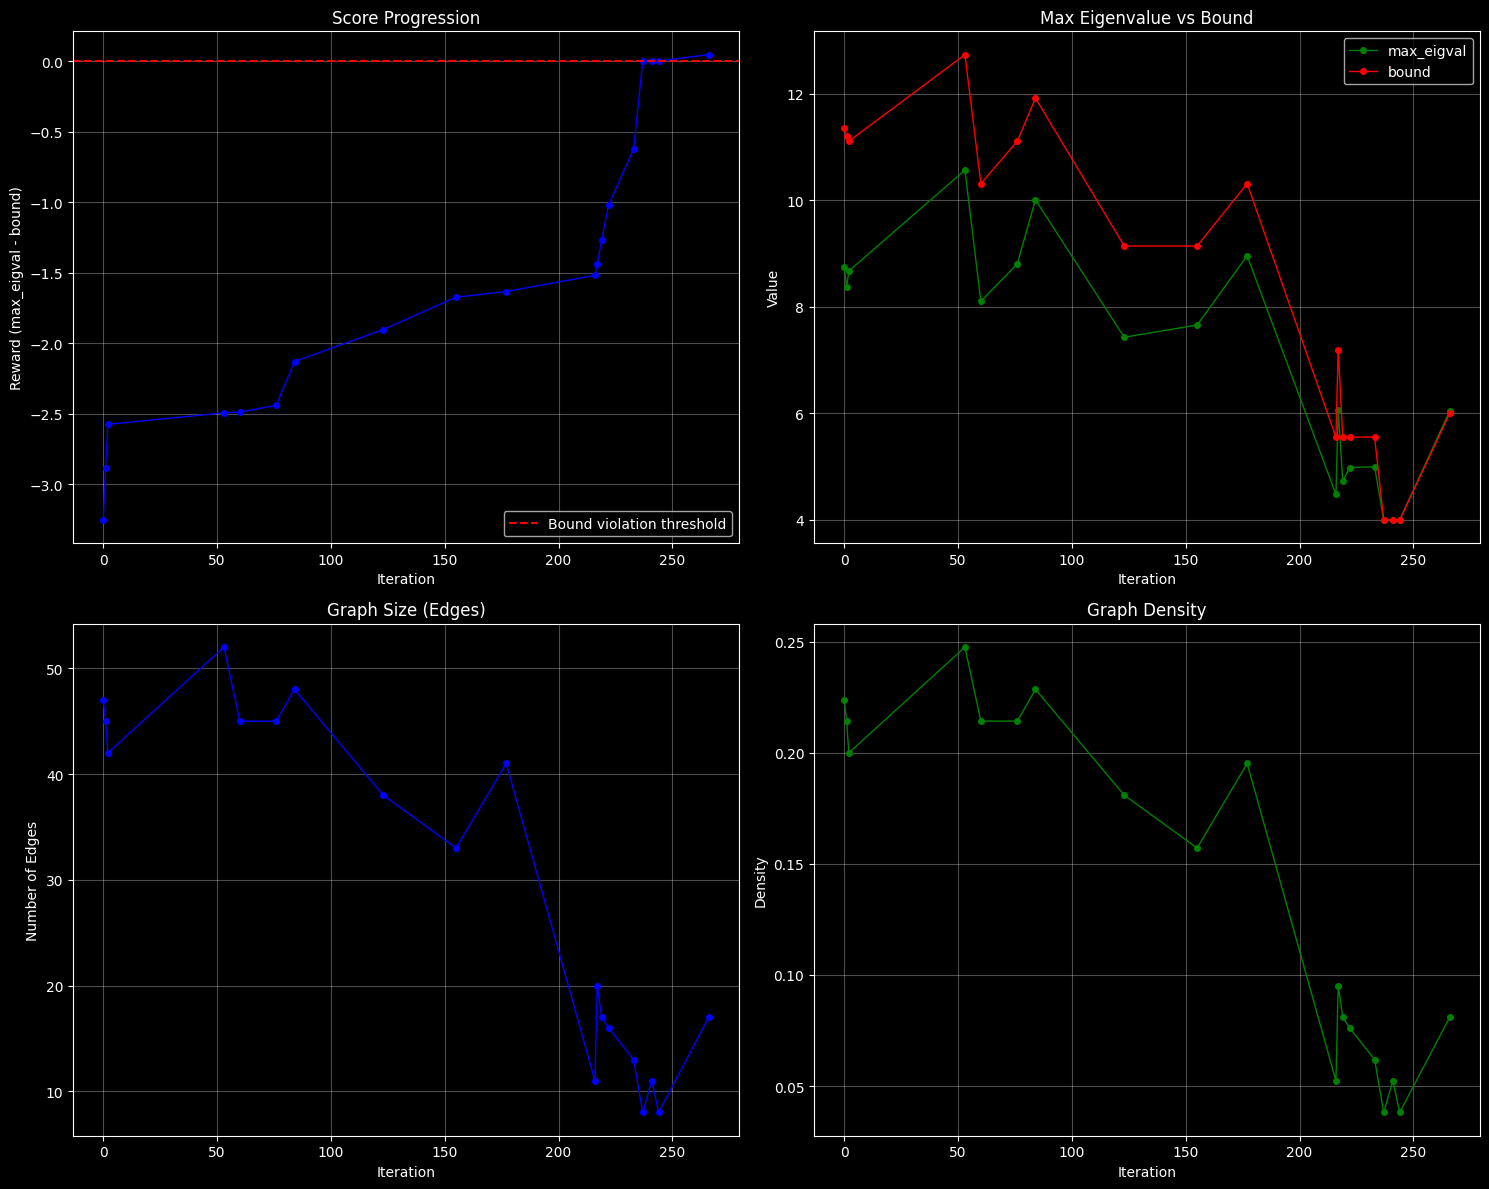

In [6]:
# Plot score progression
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

iterations = [d["iteration"] for d in constructions_data]
scores = [d["score"] for d in constructions_data]
max_eigvals = [d["max_eigval"] for d in constructions_data]
bounds = [d["bound"] for d in constructions_data]

# Score progression
axes[0, 0].plot(iterations, scores, "b-o", markersize=4, linewidth=1)
axes[0, 0].axhline(y=0, color="r", linestyle="--", label="Bound violation threshold")
axes[0, 0].set_xlabel("Iteration")
axes[0, 0].set_ylabel("Reward (max_eigval - bound)")
axes[0, 0].set_title("Score Progression")
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Max eigenvalue vs bound
axes[0, 1].plot(iterations, max_eigvals, "g-o", markersize=4, label="max_eigval", linewidth=1)
axes[0, 1].plot(iterations, bounds, "r-o", markersize=4, label="bound", linewidth=1)
axes[0, 1].set_xlabel("Iteration")
axes[0, 1].set_ylabel("Value")
axes[0, 1].set_title("Max Eigenvalue vs Bound")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Graph properties
num_edges = [d["num_edges"] for d in constructions_data]
densities = [d["density"] for d in constructions_data]
avg_degrees = [d["avg_degree"] for d in constructions_data]

axes[1, 0].plot(iterations, num_edges, "b-o", markersize=4, linewidth=1)
axes[1, 0].set_xlabel("Iteration")
axes[1, 0].set_ylabel("Number of Edges")
axes[1, 0].set_title("Graph Size (Edges)")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(iterations, densities, "g-o", markersize=4, linewidth=1)
axes[1, 1].set_xlabel("Iteration")
axes[1, 1].set_ylabel("Density")
axes[1, 1].set_title("Graph Density")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


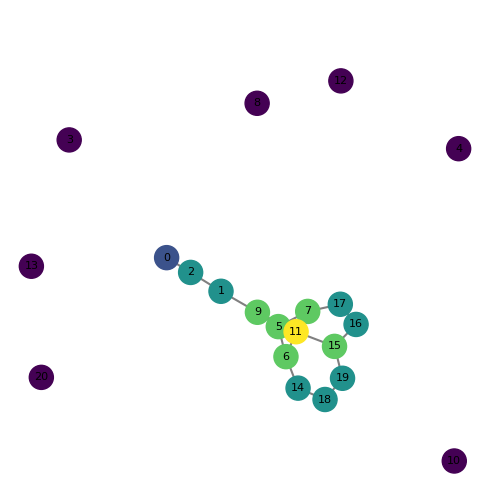

In [7]:
# Visualize the violating graphs
if violating:
    num_violating = len(violating)
    fig, axes = plt.subplots(1, min(num_violating, 5), figsize=(5 * min(num_violating, 5), 5))
    
    if num_violating == 1:
        axes = [axes]
    
    for idx, v in enumerate(violating[:5]):  # Show up to 5 violating graphs
        G = v["graph"]
        pos = nx.spring_layout(G, seed=42)
        
        # Color nodes by degree
        degrees = v["degrees"]
        node_colors = [degrees[node] for node in G.nodes()]
        
        nx.draw(
            G,
            pos,
            ax=axes[idx],
            node_color=node_colors,
            node_size=300,
            cmap=plt.get_cmap("viridis"),
            with_labels=True,
            font_size=8,
            edge_color="gray",
            width=1.5,
        )
        
        axes[idx].set_title(
            f"Iter {v['iteration']}\n"
            f"max_eigval={v['max_eigval']:.3f}, bound={v['bound']:.3f}\n"
            f"reward={v['reward']:.4f}, edges={v['num_edges']}",
            fontsize=10
        )
    
    plt.tight_layout()
    plt.show()
else:
    print("No graphs violate the bound.")


In [8]:
# Detailed analysis of the best violating graph
if violating:
    best_violating = max(violating, key=lambda x: x["reward"])
    
    print("=" * 60)
    print(f"Best Violating Graph (Iteration {best_violating['iteration']})")
    print("=" * 60)
    print(f"Reward (max_eigval - bound): {best_violating['reward']:.6f}")
    print(f"Max Laplacian Eigenvalue: {best_violating['max_eigval']:.6f}")
    print(f"Bound Value: {best_violating['bound']:.6f}")
    print(f"\nGraph Properties:")
    print(f"  Number of vertices: {problem.n}")
    print(f"  Number of edges: {best_violating['num_edges']}")
    print(f"  Density: {best_violating['density']:.4f}")
    print(f"  Is connected: {best_violating['is_connected']}")
    print(f"  Number of components: {best_violating['num_components']}")
    print(f"  Average degree: {best_violating['avg_degree']:.2f}")
    print(f"  Min degree: {best_violating['min_degree']}")
    print(f"  Max degree: {best_violating['max_degree']}")
    print(f"\nDegree Distribution:")
    degrees = best_violating['degrees']
    unique, counts = np.unique(degrees, return_counts=True)
    for deg, count in zip(unique, counts):
        print(f"  Degree {int(deg)}: {count} vertices")
    
    print(f"\nAverage Neighbor Degrees:")
    avg_neighbor = best_violating['avg_neighbor_degrees']
    print(f"  Min: {avg_neighbor.min():.4f}")
    print(f"  Max: {avg_neighbor.max():.4f}")
    print(f"  Mean: {avg_neighbor.mean():.4f}")
    
    # Show which vertex gives the bound
    degrees_tensor = torch.tensor(best_violating['degrees']).unsqueeze(0)
    avg_neighbor_tensor = torch.tensor(best_violating['avg_neighbor_degrees']).unsqueeze(0)
    vertex_scores = problem.bound(degrees_tensor, avg_neighbor_tensor)
    bound_vertex = torch.argmax(vertex_scores).item()
    print(f"\nVertex contributing to bound (vertex {bound_vertex}):")
    print(f"  Degree: {int(degrees[bound_vertex])}")
    print(f"  Avg neighbor degree: {avg_neighbor[bound_vertex]:.4f}")
    print(f"  Bound contribution: {vertex_scores[0, bound_vertex].item():.4f}")
else:
    print("No graphs violate the bound.")


Best Violating Graph (Iteration 266)
Reward (max_eigval - bound): 0.045898
Max Laplacian Eigenvalue: 6.045898
Bound Value: 6.000000

Graph Properties:
  Number of vertices: 21
  Number of edges: 17
  Density: 0.0810
  Is connected: False
  Number of components: 8
  Average degree: 1.62
  Min degree: 0
  Max degree: 4

Degree Distribution:
  Degree 0: 7 vertices
  Degree 1: 1 vertices
  Degree 2: 7 vertices
  Degree 3: 5 vertices
  Degree 4: 1 vertices

Average Neighbor Degrees:
  Min: 0.0000
  Max: 3.0000
  Mean: 1.6984

Vertex contributing to bound (vertex 5):
  Degree: 3
  Avg neighbor degree: 3.0000
  Bound contribution: 6.0000


In [9]:
# Compare bound31 with other bounds on the violating graph
if violating:
    best_violating = max(violating, key=lambda x: x["reward"])
    
    degrees_tensor = torch.tensor(best_violating['degrees']).unsqueeze(0)
    avg_neighbor_tensor = torch.tensor(best_violating['avg_neighbor_degrees']).unsqueeze(0)
    
    bounds_comparison = {}
    for bound_name, bound_func in [("bound1", bound1), ("bound4", bound4), ("bound5", bound5), ("bound31", bound31)]:
        vertex_scores = bound_func(degrees_tensor, avg_neighbor_tensor)
        bound_value = torch.max(vertex_scores).item()
        bounds_comparison[bound_name] = bound_value
    
    print("Bound Comparison on Violating Graph:")
    print(f"Max Laplacian Eigenvalue: {best_violating['max_eigval']:.6f}")
    print("\nBound values:")
    for bound_name, bound_value in bounds_comparison.items():
        violates = best_violating['max_eigval'] > bound_value
        status = "VIOLATES" if violates else "satisfies"
        print(f"  {bound_name:8s}: {bound_value:8.4f} ({status})")
else:
    print("No graphs violate the bound.")


W1112 10:15:44.967000 3406060 .venv/lib/python3.13/site-packages/torch/utils/cpp_extension.py:117] [0/0] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Bound Comparison on Violating Graph:
Max Laplacian Eigenvalue: 6.045898

Bound values:
  bound1  :      nan (satisfies)
  bound4  :      nan (satisfies)
  bound5  :      nan (satisfies)
  bound31 :   6.0000 (VIOLATES)


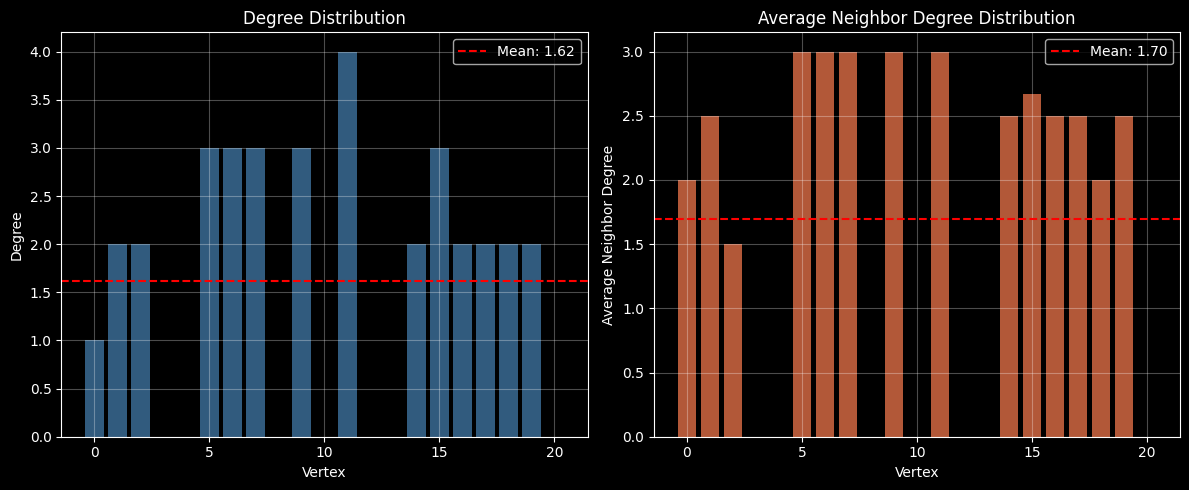

In [10]:
# Visualize degree distribution and average neighbor degrees
if violating:
    best_violating = max(violating, key=lambda x: x["reward"])
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Degree distribution
    degrees = best_violating['degrees']
    axes[0].bar(range(len(degrees)), degrees, alpha=0.7, color='steelblue')
    axes[0].axhline(y=degrees.mean(), color='r', linestyle='--', label=f'Mean: {degrees.mean():.2f}')
    axes[0].set_xlabel('Vertex')
    axes[0].set_ylabel('Degree')
    axes[0].set_title('Degree Distribution')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Average neighbor degrees
    avg_neighbor = best_violating['avg_neighbor_degrees']
    axes[1].bar(range(len(avg_neighbor)), avg_neighbor, alpha=0.7, color='coral')
    axes[1].axhline(y=avg_neighbor.mean(), color='r', linestyle='--', label=f'Mean: {avg_neighbor.mean():.2f}')
    axes[1].set_xlabel('Vertex')
    axes[1].set_ylabel('Average Neighbor Degree')
    axes[1].set_title('Average Neighbor Degree Distribution')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No graphs violate the bound.")


In [11]:
# Export the violating graph for further analysis
if violating:
    best_violating = max(violating, key=lambda x: x["reward"])
    
    # Save as NetworkX graph
    output_file = Path(f"violating_graph_iter_{best_violating['iteration']}_score_{best_violating['reward']:.4f}.graphml")
    nx.write_graphml(best_violating['graph'], output_file)
    print(f"Saved violating graph to: {output_file}")
    
    # Save adjacency matrix
    adj_file = Path("violating_graph_adjacency.npy")
    np.save(adj_file, best_violating['adj'])
    print(f"Saved adjacency matrix to: {adj_file}")
else:
    print("No graphs violate the bound.")


Saved violating graph to: violating_graph_iter_266_score_0.0459.graphml
Saved adjacency matrix to: violating_graph_adjacency.npy
